<a href="https://colab.research.google.com/github/RhysWangJunfei/nilm/blob/master/nilm_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import io
from google.colab import files
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier as gbdt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [0]:
'''Sliding window function'''
def create_dataset(dataset, look_back=1):
    dataX = []
    for i in range(len(dataset)-look_back+1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
    return np.array(dataX)

In [0]:
#uploaded = files.upload()
'''Load data'''
#WHE_data = pd.read_csv(io.BytesIO(uploaded['Electricity_WHE.csv']))[['unix_ts','P']]
WHE_data = pd.read_csv('Electricity_WHE.csv')[['unix_ts','P']]
#uploaded = files.upload()
#CDE_data = pd.read_csv(io.BytesIO(uploaded['Electricity_CDE.csv']))['P']
CDE_data = pd.read_csv('Electricity_CDE.csv')['P']

In [87]:
window_size=60
'''Using sliding window to build training examples'''
time_data = create_dataset(WHE_data['P'].as_matrix(), window_size)

WHE_data['datetime'] = pd.to_datetime(WHE_data['unix_ts'],unit='s')
WHE_data = WHE_data.drop(['unix_ts'],axis=1)

WHE_data['month'] = WHE_data['datetime'].dt.month
WHE_data['hour'] = WHE_data['datetime'].dt.hour
WHE_data['weekday'] = WHE_data['datetime'].dt.dayofweek
WHE_data['quarter'] = WHE_data['datetime'].dt.quarter

data_month = WHE_data['month'].as_matrix()[window_size-1:].reshape([-1,1])
data_hour = WHE_data['hour'].as_matrix()[window_size-1:].reshape([-1,1])
data_weekday = WHE_data['weekday'].as_matrix()[window_size-1:].reshape([-1,1])
dataX = np.hstack([time_data,data_month,data_hour,data_weekday])
cde_Y = CDE_data[window_size-1:].values.reshape([CDE_data.shape[0]-window_size+1,1])

dataX_train = np.concatenate([dataX[0:472500,:],dataX[475500:,:]],axis=0)
cde_Y_train = np.concatenate([cde_Y[0:472500,:],cde_Y[475500:,:]],axis=0)

time_data_number=40

dataX_train = dataX_train[:,-1*(time_data_number+3):]
print(dataX_train.shape)

cde_Y_new = (cde_Y_train==0).flatten()

(1048141, 43)


In [88]:
#PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
conponent = pca.fit_transform(dataX_train)
new_data = np.concatenate([conponent,cde_Y_new.reshape([-1,1])],axis=1)
principalDf = pd.DataFrame(data = new_data
             , columns = ['principal component 1', 'principal component 2','principal component 3','target'])
principalDf.head()

,principal component 1,principal component 2,principal component 3,target
0,3121.390253,5187.744175,-768.612871,1.0
1,2759.051062,5164.804860,-972.446611,1.0
2,2394.160028,5102.866247,-1151.631158,1.0
3,2030.236730,5009.024512,-1306.450075,1.0
4,1664.314518,4931.252392,-1426.798257,1.0


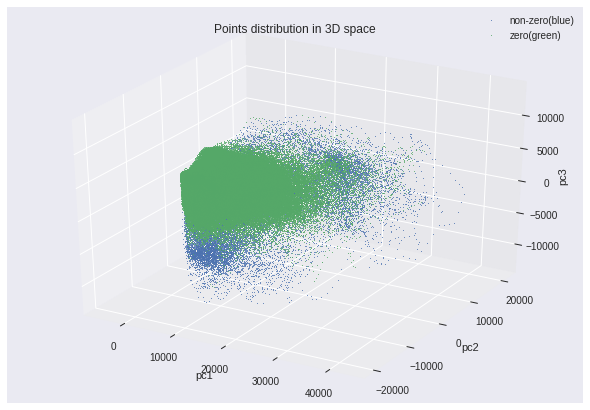

In [89]:
#visualization
groups = principalDf.groupby('target')
fig = plt.figure()
ax = Axes3D(fig)
for name, group in groups:
    ax.plot(group['principal component 1'], group['principal component 2'],group['principal component 3'], 
              marker='o', linestyle='', ms=1, label=name)
ax.legend(['non-zero(blue)','zero(green)'])
ax.set_xlabel('pc1') 
ax.set_ylabel('pc2') 
ax.set_zlabel('pc3', rotation=90) 
plt.title('Points distribution in 3D space')
plt.show()


In [0]:
#Split
X_train, X_test, y_train, y_test = train_test_split(conponent, cde_Y_new, test_size=0.1, shuffle=True)

In [0]:
#from imblearn.under_sampling import TomekLinks
#tl = TomekLinks(sampling_strategy='all')
#X_train, y_train = tl.fit_resample(X_train, y_train)

#from imblearn.under_sampling import EditedNearestNeighbours
#enn = EditedNearestNeighbours()
#X_train, y_train = enn.fit_resample(X_train, y_train)

#from imblearn.under_sampling import NeighbourhoodCleaningRule
#ncr = NeighbourhoodCleaningRule()
#X_train, y_train = ncr.fit_resample(X_train, y_train)

In [0]:
#Randomly Undersampling
whole_train_matrix = np.concatenate([X_train,y_train.reshape([-1,1])],axis=1)
whole_train_df = pd.DataFrame(whole_train_matrix)
df_class_0 = whole_train_df[whole_train_df[3] == 1]
df_class_1 = whole_train_df[whole_train_df[3] ==0]
size_0 = df_class_0.shape[0]
size_1 = df_class_1.shape[0]
df_class_0_under = df_class_0.sample(n=size_1//2)
df_under = pd.concat([df_class_0_under, df_class_1], axis=0)
df_under = df_under.rename(columns={ df_under.columns[0]: "principal component 1",df_under.columns[1]: "principal component 2",
                                    df_under.columns[2]: "principal component 3",df_under.columns[3]: "target" })
#new train matrix
X_train = df_under.values[:,0:3]
y_train = df_under.values[:,3]

        principal component 1  principal component 2  principal component 3  \
274223            2689.158252             352.997316            -200.980519   
16361            -2204.442002             221.839136             732.904385   
657420           -3557.024522             104.825753             224.573801   
661298             722.640312           -4913.617167           -1784.982980   
360730           -2862.150893            -165.008593              -4.556114   

        target  
274223     1.0  
16361      1.0  
657420     1.0  
661298     1.0  
360730     1.0  


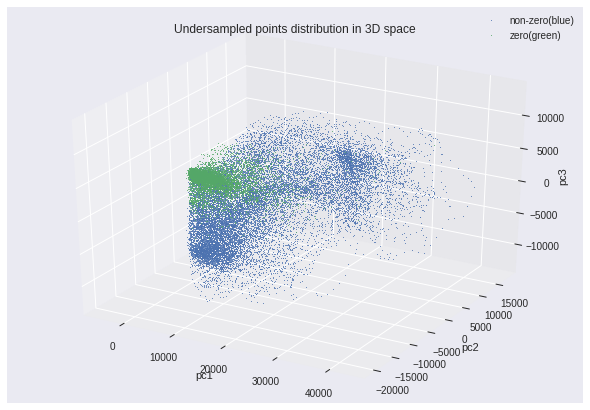

In [107]:
print(df_under.head())
groups = df_under.groupby('target')
fig = plt.figure()
ax = Axes3D(fig)
for name, group in groups:
    ax.plot(group['principal component 1'], group['principal component 2'],group['principal component 3'], 
              marker='o', linestyle='', ms=1, label=name)
ax.legend(['non-zero(blue)','zero(green)'])
ax.set_xlabel('pc1') 
ax.set_ylabel('pc2') 
ax.set_zlabel('pc3', rotation=90) 
plt.title('Undersampled points distribution in 3D space')

plt.show()
#https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html

In [0]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_neighbors':[5,7,9,11,17,27,57,129,255]}
    #5,7,9,11,17,27,57,129,255]}
#,'algorithm':('ball_tree','kd_tree','brute')


In [94]:
from sklearn.neighbors import KNeighborsClassifier as knn
model = knn()
clf = GridSearchCV(model, parameters, cv=5,scoring='f1')
clf.fit(X_train,y_train)



GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [5, 7, 9, 11, 17, 27, 57, 129, 255]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [95]:
print(clf.best_estimator_)
model = clf.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=57, p=2,
           weights='uniform')


In [96]:
pred = model.predict(X_test)
predict_acc = np.sum(pred==y_test)
print(predict_acc/y_test.size)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=pred)
print('Confusion matrix:\n', conf_mat)

0.8765348471115776
Confusion matrix:
 [[ 1824   277]
 [12664 90050]]


In [97]:
df = pd.Series(y_test)
df.value_counts()

True     102714
False      2101
dtype: int64

In [0]:
import pickle
file_name='cde_binary_knn'
fileObject = open(file_name,'wb')
pickle.dump(model,fileObject)

In [0]:
from google.colab import files

files.download('cde_binary_knn')

In [0]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Normalized confusion matrix
[[0.87 0.13]
 [0.12 0.88]]


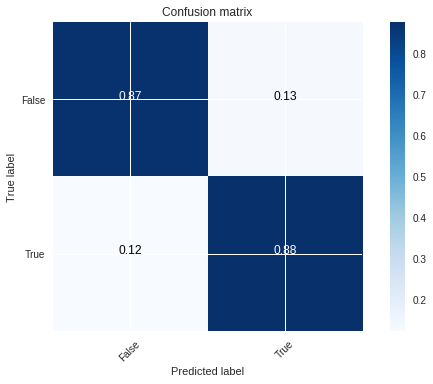

In [101]:
# Compute confusion matrix
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['False','True'],normalize=True,
                      title='Confusion matrix')

# Plot normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(conf_mat, classes=class_names, normalize=True,
 #                     title='Normalized confusion matrix')

plt.show()